In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import torchtext
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

debug = False

print("Pytorch: \t\t", torch.__version__)
if not debug and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.10.2+cu102
GPU:         		 NVIDIA GeForce GTX 1660 Ti
Memory Usage:	 0.0 GB /  0.0 GB


In [2]:
# Initializing parameters

batch_size = 32     # Reduce this if you get memory errors

seed = 2476          # A random seed to get replicable results

sequence_max_length = 250

vocab_size = 10000

In [3]:
train_dataset, test_dataset = torchtext.datasets.IMDB(split=('train', 'test'))

In [4]:

from torchtext.data.functional import to_map_style_dataset

train_dataset = to_map_style_dataset(train_dataset)
test_dataset = to_map_style_dataset(test_dataset)

In [5]:
from collections import Counter, OrderedDict

def build_vocab_from_iterator(iterator, min_freq: int = 1, specials = [], special_first: bool = True, vocab_size = None):
    counter = Counter()
    for tokens in iterator:
        counter.update(tokens)

    if specials is not None:
        for tok in specials:
            del counter[tok]

    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[0])
    sorted_by_freq_tuples.sort(key=lambda x: x[1], reverse=True)
    
    if vocab_size is not None:
        sorted_by_freq_tuples = sorted_by_freq_tuples[:vocab_size]

    ordered_dict = OrderedDict(sorted_by_freq_tuples)

    if specials is not None:
        if special_first:
            specials = specials[::-1]
        for symbol in specials:
            ordered_dict.update({symbol: min_freq})
            ordered_dict.move_to_end(symbol, last=not special_first)

    word_vocab = torchtext.vocab.vocab(ordered_dict, min_freq=min_freq)
    return word_vocab


In [6]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<pad>", "<unk>"], vocab_size=10000-2)
vocab.set_default_index(vocab["<unk>"])

pad_id = vocab['<pad>']

In [7]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [8]:
pad_id

0

## Avoiding ValueError (using a target size different to the input size)

```ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.```

Simply add `.unsqueeze(-1)` to the end of your label tensor.



In [9]:
def collate_batch(batch):
     label_list, text_list = [], []
     for (label, text) in batch:
          input = text_pipeline(text)
          label_list.append(torch.tensor([label_pipeline(label)], dtype=torch.float32))
          
          a = torch.tensor(input[:sequence_max_length], dtype=torch.int64)
          b = torch.zeros(max(0, sequence_max_length - len(input)), dtype=torch.int64)
          text_list.append(torch.cat((a,b)))
               
     label_list = torch.stack(label_list)
     text_list = torch.stack(text_list)
     return text_list, label_list

In [10]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=8,
    batch_size=batch_size,
    collate_fn=collate_batch)

test_dataloader = DataLoader(
    test_dataset, 
    num_workers=8,
    batch_size=batch_size, 
    collate_fn=collate_batch)


In [11]:

for X, y in train_dataloader:
    print("Shape of X: ", X.shape)
    print("Labels : ", y.shape)
    print("SAMPLE")
    print("Label: ",y[0].item())
    print("Text:")
    print(" ".join(vocab.lookup_tokens(X[0].tolist())))
    # print(X, y, o)
    break

Shape of X:  torch.Size([32, 250])
Labels :  torch.Size([32, 1])
SAMPLE
Label:  1.0
Text:
whether it ' s three guys in their <unk> <unk> to a dude bound in <unk> or a girl saying what up , dog ? to a <unk> of <unk> , there ' s something please everyone in <unk> jones . it is strange and surreal and not altogether a completely <unk> yarn . . . yet it never loses you . the first time i saw it , i nearly laughed myself sick . and every night after i would come home and watch it again . forget <unk> ugly . . . this is the movie that <unk> my crush on piper <unk> . see it . . . before it ' s too late ! <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [12]:
from torch import nn

class ClassifyNet(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        # self.pool = nn.AvgPool1d(3, stride=2)
        self.fc = nn.Linear(embed_dim, num_class)
        self.dropout = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.emb(x)
        # print(x.shape)
        x = self.dropout(x)
        x = torch.mean(x, 1)
        x = self.dropout2(x)
        # print(x.shape)
        x = self.fc(x)

        return torch.sigmoid(x)

In [13]:
a = torch.randn(32, 250, 16)
torch.mean(a, 1).shape

torch.Size([32, 16])

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    accuracy = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        #FORWARD PASS
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            loss += loss_fn(pred, y).item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy

In [15]:
emsize = 16
num_classes = 1
vocab_size = len(vocab)

model = ClassifyNet(vocab_size, emsize, num_classes).to(device)
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())



In [16]:
count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count}")

Number of trainable parameters: 160017


In [17]:
epochs = 10
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, history)
    test_loop(test_dataloader, model, loss_fn, history)

00:35 Elapsed | 100% done |██████████| 10/10 [00:00 remaining |  3.54s/epoch]


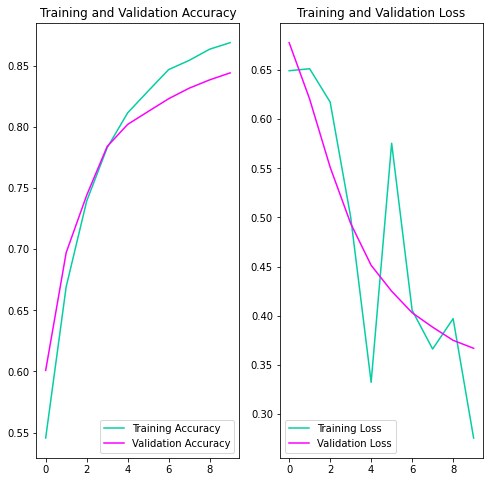

In [18]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()
